In [1]:
from numba import cuda, float32
from numba.cuda import as_cuda_array
import numpy as np
import torch
import math

import triton
import triton.language as tl
from triton.runtime import driver

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


@cuda.jit
def numba_softmax_kernel(x, y, num_rows, num_cols):
    """Softmax kernel - same as before"""
    row = cuda.blockIdx.x
    tid = cuda.threadIdx.x
    block_size = cuda.blockDim.x
    
    shared_max = cuda.shared.array(1024, float32)
    shared_sum = cuda.shared.array(1024, float32)
    
    if row >= num_rows:
        return
    
    # Step 1: Find max
    thread_max = float('-inf')
    for col in range(tid, num_cols, block_size):
        val = x[row, col]
        if val > thread_max:
            thread_max = val
    
    shared_max[tid] = thread_max
    cuda.syncthreads()
    
    stride = block_size // 2
    while stride > 0:
        if tid < stride:
            if shared_max[tid + stride] > shared_max[tid]:
                shared_max[tid] = shared_max[tid + stride]
        cuda.syncthreads()
        stride //= 2
    
    row_max = shared_max[0]
    cuda.syncthreads()
    
    # Step 2: Compute exp and sum
    thread_sum = 0.0
    for col in range(tid, num_cols, block_size):
        val = x[row, col] - row_max
        exp_val = math.exp(val)
        y[row, col] = exp_val
        thread_sum += exp_val
    
    shared_sum[tid] = thread_sum
    cuda.syncthreads()
    
    stride = block_size // 2
    while stride > 0:
        if tid < stride:
            shared_sum[tid] += shared_sum[tid + stride]
        cuda.syncthreads()
        stride //= 2
    
    row_sum = shared_sum[0]
    cuda.syncthreads()
    
    # Step 3: Normalize
    for col in range(tid, num_cols, block_size):
        y[row, col] = y[row, col] / row_sum


def numba_softmax(x):
    """
    Efficient softmax that works directly with PyTorch CUDA tensors.
    
    Args:
        x: 2D PyTorch CUDA tensor or NumPy array
    
    Returns:
        y: PyTorch CUDA tensor or device array
    """
    # Handle PyTorch tensors
    if isinstance(x, torch.Tensor):
        if not x.is_cuda:
            x = x.cuda()
        
        # Create output tensor
        y = torch.empty_like(x)
        
        # Get CUDA array interface from PyTorch tensors
        # This is zero-copy!
        x_numba = cuda.as_cuda_array(x.detach())
        y_numba = cuda.as_cuda_array(y)
        
        # Launch kernel
        num_rows, num_cols = x.shape
        threads_per_block = min(1024, 2**math.ceil(math.log2(num_cols)))
        threads_per_block = max(32, threads_per_block)
        blocks = num_rows
        
        numba_softmax_kernel[blocks, threads_per_block](
            x_numba, y_numba, num_rows, num_cols
        )
        cuda.synchronize()
        return y
    
    # Handle NumPy arrays (original behavior)
    else:
        x_device = cuda.to_device(x.astype(np.float32))
        y_device = cuda.device_array(x_device.shape, dtype=np.float32)
        
        num_rows, num_cols = x_device.shape
        threads_per_block = min(1024, 2**math.ceil(math.log2(num_cols)))
        threads_per_block = max(32, threads_per_block)
        blocks = num_rows
        
        numba_softmax_kernel[blocks, threads_per_block](
            x_device, y_device, num_rows, num_cols
        )
        cuda.synchronize()
        return y_device

In [2]:


# ============================================
# Usage Example
# ============================================
if __name__ == "__main__":
    # Test data
    M, N = 100, 512  # 100 rows, 512 columns
    x = np.random.randn(M, N).astype(np.float32)
    
    # Compute softmax
    y_device = numba_softmax(x)
    y = y_device.copy_to_host()
    
    # Verify with numpy
    def numpy_softmax(x):
        x_max = np.max(x, axis=1, keepdims=True)
        exp_x = np.exp(x - x_max)
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    y_expected = numpy_softmax(x)
    
    print(f"Input shape: {x.shape}")
    print(f"Output shape: {y.shape}")
    print(f"Max difference: {np.max(np.abs(y - y_expected)):.2e}")
    print(f"Row sums (should be ~1.0): {y.sum(axis=1)[:5]}")
    print(f"Match: {np.allclose(y, y_expected, rtol=1e-5)}")

/home/lelarge/miniconda3/envs/cs336-syst/lib/python3.11/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 100 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Input shape: (100, 512)
Output shape: (100, 512)
Max difference: 7.45e-09
Row sums (should be ~1.0): [1.        1.        0.9999999 1.        1.       ]
Match: True


In [3]:
@triton.jit
def triton_softmax_kernel(x_ptr, y_ptr, x_row_stride, y_row_stride, num_cols, BLOCK_SIZE: tl.constexpr):
    assert num_cols <= BLOCK_SIZE
    # Process each row independently
    row_idx = tl.program_id(0)
    col_offsets = tl.arange(0, BLOCK_SIZE)
    # Read from global memory
    x_start_ptr = x_ptr + row_idx * x_row_stride
    x_ptrs = x_start_ptr + col_offsets
    x_row = tl.load(x_ptrs, mask=col_offsets < num_cols, other=float("-inf"))
    # Compute
    x_row = x_row - tl.max(x_row, axis=0)
    numerator = tl.exp(x_row)
    denominator = tl.sum(numerator, axis=0)
    y_row = numerator / denominator
    # Write back to global memory
    y_start_ptr = y_ptr + row_idx * y_row_stride
    y_ptrs = y_start_ptr + col_offsets
    tl.store(y_ptrs, y_row, mask=col_offsets < num_cols)

def triton_softmax(x: torch.Tensor):
    # Allocate output tensor
    y = torch.empty_like(x)
    # Determine grid
    M, N = x.shape                          # Number of rows x number of columns
    block_size = triton.next_power_of_2(N)  # Each block contains all the columns
    num_blocks = M                          # Each block is a row
    # Launch kernel
    triton_softmax_kernel[(M,)](
        x_ptr=x, y_ptr=y,
        x_row_stride=x.stride(0), y_row_stride=y.stride(0),
        num_cols=N, BLOCK_SIZE=block_size
    )
    return y

In [4]:
torch.manual_seed(0)
x = torch.randn(1823, 781, device=DEVICE)
y_triton = triton_softmax(x)
y_torch = torch.softmax(x, axis=1)
assert torch.allclose(y_triton, y_torch), (y_triton, y_torch)

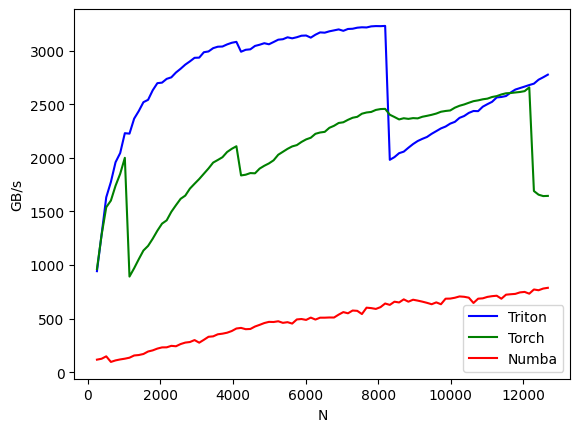

softmax-performance:
          N       Triton        Torch       Numba
0     256.0   942.599430   962.352543  116.713841
1     384.0  1284.997113  1280.739862  125.222578
2     512.0  1632.157679  1539.247509  147.621745
3     640.0  1775.181088  1601.397047   95.504593
4     768.0  1959.073713  1739.864201  109.705874
5     896.0  2045.441503  1851.393407  118.742315
6    1024.0  2230.360336  2000.460017  125.721024
7    1152.0  2226.269206   892.094129  134.913268
8    1280.0  2365.972167   969.764271  155.678533
9    1408.0  2437.340114  1054.519034  159.851878
10   1536.0  2519.855301  1135.368979  169.503572
11   1664.0  2541.779291  1178.560340  192.703724
12   1792.0  2631.167128  1245.641857  203.364040
13   1920.0  2697.423963  1320.546941  219.980579
14   2048.0  2702.185582  1386.230323  231.086530
15   2176.0  2737.422023  1416.944783  231.736881
16   2304.0  2751.662553  1496.467381  245.536246
17   2432.0  2796.886312  1558.519602  241.740017
18   2560.0  2831.802350  161

In [5]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(2, 100)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton', 'torch', 'numba'],  # possible values for `line_arg``
        line_names=["Triton", "Torch", "Numba"],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('red', '-')],  # line styles
        ylabel="GB/s",  # label name for the y-axis
        plot_name="softmax-performance",  # name for the plot. Used also as a file name for saving the plot.
        args={'M': 4096},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(M, N, provider):
    x = torch.randn(M, N, device=DEVICE, dtype=torch.float32)
    stream = getattr(torch, DEVICE.type).Stream()
    getattr(torch, DEVICE.type).set_stream(stream)
    if provider == 'torch':
        ms = triton.testing.do_bench(lambda: torch.softmax(x, axis=-1))
    if provider == 'triton':
        ms = triton.testing.do_bench(lambda: triton_softmax(x))
    if provider == 'numba':
        ms = triton.testing.do_bench(lambda: numba_softmax(x))
    gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms)


benchmark.run(show_plots=True, print_data=True)

In [6]:
import torch
import triton
from numba import cuda

def check_occupancy():
    M, N = 4096, 12000
    x = torch.randn(M, N, device='cuda', dtype=torch.float32)
    
    print("="*60)
    print("NUMBA CONFIGURATION")
    print("="*60)
    threads_per_block = min(1024, 2**math.ceil(math.log2(N)))
    print(f"Threads per block: {threads_per_block}")
    print(f"Number of blocks: {M}")
    print(f"Total thread contexts: {M * threads_per_block:,}")
    print(f"Blocks per SM (theoretical): {M / 132:.1f}")
    
    print("\n" + "="*60)
    print("TRITON CONFIGURATION")
    print("="*60)
    BLOCK_SIZE = triton.next_power_of_2(N)
    print(f"BLOCK_SIZE (compile-time): {BLOCK_SIZE}")
    print(f"Number of programs: {M}")
    print(f"Programs per SM (theoretical): {M / 132:.1f}")
    
    print("\n" + "="*60)
    print("H100 SPECS")
    print("="*60)
    device = cuda.get_current_device()
    print(f"Number of SMs: {device.MULTIPROCESSOR_COUNT}")
    print(f"Max threads per SM: ~2048")
    print(f"Total concurrent thread capacity: ~{device.MULTIPROCESSOR_COUNT * 2048:,}")
    
    # Saturation
    numba_threads = M * threads_per_block
    triton_programs = M
    
    print("\n" + "="*60)
    print("SATURATION ANALYSIS")
    print("="*60)
    print(f"Numba thread contexts: {numba_threads:,}")
    print(f"Triton programs: {triton_programs:,}")
    print(f"Numba saturation: {numba_threads / (132 * 2048) * 100:.1f}%")

check_occupancy()

NUMBA CONFIGURATION
Threads per block: 1024
Number of blocks: 4096
Total thread contexts: 4,194,304
Blocks per SM (theoretical): 31.0

TRITON CONFIGURATION
BLOCK_SIZE (compile-time): 16384
Number of programs: 4096
Programs per SM (theoretical): 31.0

H100 SPECS
Number of SMs: 132
Max threads per SM: ~2048
Total concurrent thread capacity: ~270,336

SATURATION ANALYSIS
Numba thread contexts: 4,194,304
Triton programs: 4,096
Numba saturation: 1551.5%


In [7]:
def analyze_execution_waves():
    M, N = 4096, 12000
    
    # H100 specs
    SMs = 132
    max_threads_per_sm = 2048
    
    print("="*60)
    print("NUMBA EXECUTION ANALYSIS")
    print("="*60)
    
    # Numba config
    threads_per_block = 512
    total_blocks = M
    
    # How many blocks fit per SM?
    blocks_per_sm_limit_threads = max_threads_per_sm // threads_per_block  # 4
    
    # Assuming no other limits (shared memory, registers are fine)
    blocks_per_sm = blocks_per_sm_limit_threads
    
    concurrent_blocks = SMs * blocks_per_sm
    num_waves = (total_blocks + concurrent_blocks - 1) // concurrent_blocks
    
    print(f"Threads per block: {threads_per_block}")
    print(f"Total blocks: {total_blocks}")
    print(f"Blocks per SM (concurrent): {blocks_per_sm}")
    print(f"Concurrent blocks: {concurrent_blocks}")
    print(f"Execution waves: {num_waves}")
    print(f"Efficiency: {total_blocks / (num_waves * concurrent_blocks) * 100:.1f}%")
    
    print("\n" + "="*60)
    print("TRITON EXECUTION ANALYSIS")
    print("="*60)
    
    # Triton: harder to analyze without knowing internal thread count
    # But we can make educated guesses
    
    total_programs = M
    
    # Hypothesis 1: Triton uses fewer threads per program
    for triton_threads in [32, 64, 128, 256]:
        programs_per_sm = max_threads_per_sm // triton_threads
        concurrent_programs = SMs * programs_per_sm
        waves = (total_programs + concurrent_programs - 1) // concurrent_programs
        
        print(f"\nIf Triton uses {triton_threads} threads per program:")
        print(f"  Programs per SM: {programs_per_sm}")
        print(f"  Concurrent programs: {concurrent_programs}")
        print(f"  Execution waves: {waves}")
        print(f"  Efficiency: {total_programs / (waves * concurrent_programs) * 100:.1f}%")

analyze_execution_waves()

NUMBA EXECUTION ANALYSIS
Threads per block: 512
Total blocks: 4096
Blocks per SM (concurrent): 4
Concurrent blocks: 528
Execution waves: 8
Efficiency: 97.0%

TRITON EXECUTION ANALYSIS

If Triton uses 32 threads per program:
  Programs per SM: 64
  Concurrent programs: 8448
  Execution waves: 1
  Efficiency: 48.5%

If Triton uses 64 threads per program:
  Programs per SM: 32
  Concurrent programs: 4224
  Execution waves: 1
  Efficiency: 97.0%

If Triton uses 128 threads per program:
  Programs per SM: 16
  Concurrent programs: 2112
  Execution waves: 2
  Efficiency: 97.0%

If Triton uses 256 threads per program:
  Programs per SM: 8
  Concurrent programs: 1056
  Execution waves: 4
  Efficiency: 97.0%


In [8]:
from numba import cuda, float32
import numpy as np
import math

def check_kernel_info():
    """
    Working version - only uses available attributes
    """
    # Simple test kernel
    @cuda.jit
    def test_kernel(x, y, num_rows, num_cols):
        row = cuda.blockIdx.x
        tid = cuda.threadIdx.x
        block_size = cuda.blockDim.x
        
        shared_max = cuda.shared.array(1024, float32)
        shared_sum = cuda.shared.array(1024, float32)
        
        if row >= num_rows:
            return
        
        thread_max = float('-inf')
        for col in range(tid, num_cols, block_size):
            val = x[row, col]
            if val > thread_max:
                thread_max = val
        
        shared_max[tid] = thread_max
        cuda.syncthreads()
    
    # Compile by launching once
    x = cuda.to_device(np.random.randn(10, 512).astype(np.float32))
    y = cuda.device_array((10, 512), dtype=np.float32)
    test_kernel[10, 512](x, y, 10, 512)
    cuda.synchronize()
    
    print("="*60)
    print("NUMBA KERNEL INSPECTION")
    print("="*60)
    
    # Check what's actually available
    print("\nAvailable methods:")
    methods = [m for m in dir(test_kernel) if not m.startswith('_')]
    for method in methods[:20]:
        print(f"  - {method}")
    
    # Try PTX inspection
    print("\n" + "="*60)
    print("PTX CODE (GPU Assembly)")
    print("="*60)
    try:
        # Get the signature we compiled
        sig = (cuda.float32[:, :], cuda.float32[:, :], cuda.int32, cuda.int32)
        ptx = test_kernel.inspect_asm(sig)
        
        # Extract register info from PTX
        ptx_str = str(ptx)
        lines = ptx_str.split('\n')
        
        print("\nRegister declarations:")
        for line in lines[:100]:
            if '.reg' in line:
                print(f"  {line.strip()}")
        
        # Look for register count
        for line in lines:
            if 'reg,' in line or 'registers' in line.lower():
                print(f"  {line.strip()}")
                
    except Exception as e:
        print(f"PTX inspection failed: {e}")
    
    # Manually calculate what we know
    print("\n" + "="*60)
    print("KNOWN RESOURCE USAGE")
    print("="*60)
    print(f"Shared memory: 2 × 1024 × 4 = 8,192 bytes (8 KB)")
    print(f"Threads per block: 512")
    print(f"Syncthreads calls: ~18 per block")

check_kernel_info()

NUMBA KERNEL INSPECTION

Available methods:
  - add_overload
  - call
  - compile
  - compile_device
  - configure
  - disable_compile
  - doc
  - dump
  - enable_caching
  - extensions
  - fold_argument_types
  - forall
  - func_code
  - get_annotation_info
  - get_call_template
  - get_compile_result
  - get_const_mem_size
  - get_function_type
  - get_local_mem_per_thread
  - get_max_threads_per_block

PTX CODE (GPU Assembly)
PTX inspection failed: module 'numba.cuda' has no attribute 'float32'

KNOWN RESOURCE USAGE
Shared memory: 2 × 1024 × 4 = 8,192 bytes (8 KB)
Threads per block: 512
Syncthreads calls: ~18 per block


/home/lelarge/miniconda3/envs/cs336-syst/lib/python3.11/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 10 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


In [9]:
import torch
import numpy as np

def profile_detailed():
    sizes = [256, 512, 1024, 2048, 4096, 12000]
    M = 4096
    
    print("N\tNumba(ms)\tTriton(ms)\tRatio")
    print("="*50)
    
    for N in sizes:
        x = torch.randn(M, N, device='cuda', dtype=torch.float32)
        
        # Warm up
        for _ in range(10):
            _ = numba_softmax(x)
            _ = triton_softmax(x)
        torch.cuda.synchronize()
        
        # Benchmark
        start = torch.cuda.Event(enable_timing=True)
        end = torch.cuda.Event(enable_timing=True)
        
        # Numba
        start.record()
        for _ in range(100):
            _ = numba_softmax(x)
        end.record()
        torch.cuda.synchronize()
        numba_time = start.elapsed_time(end) / 100
        
        # Triton
        start.record()
        for _ in range(100):
            _ = triton_softmax(x)
        end.record()
        torch.cuda.synchronize()
        triton_time = start.elapsed_time(end) / 100
        
        ratio = triton_time / numba_time
        print(f"{N}\t{numba_time:.3f}\t\t{triton_time:.3f}\t\t{ratio:.2f}x")

profile_detailed()

N	Numba(ms)	Triton(ms)	Ratio
256	0.126		0.021		0.17x
512	0.172		0.028		0.17x
1024	0.307		0.022		0.07x
2048	0.346		0.023		0.07x
4096	0.368		0.044		0.12x
12000	0.577		0.146		0.25x


In [1]:
from numba import cuda
import numpy as np

def show_gpu_info():
    if not cuda.is_available():
        print("No CUDA GPU available")
        return
    
    print(f"Number of GPUs: {len(cuda.gpus)}\n")
    
    for i, gpu in enumerate(cuda.gpus):
        print(f"{'='*60}")
        print(f"GPU {i}: {gpu.name.decode('utf-8')}")
        print(f"{'='*60}")
        
        with cuda.gpus[i]:
            device = cuda.get_current_device()
            
            # Helper function to safely get attribute
            def safe_get(attr_name, default="N/A"):
                try:
                    return getattr(device, attr_name)
                except AttributeError:
                    return default
            
            # Basic info
            print(f"\n📊 BASIC INFO:")
            print(f"  Compute Capability: {device.compute_capability}")
            print(f"  PCI Device ID: {device.id}")
            
            # Thread/Block limits
            print(f"\n🧵 THREAD LIMITS:")
            print(f"  Max threads per block: {safe_get('MAX_THREADS_PER_BLOCK')}")
            print(f"  Max block dimensions: {safe_get('MAX_BLOCK_DIM_X')} × {safe_get('MAX_BLOCK_DIM_Y')} × {safe_get('MAX_BLOCK_DIM_Z')}")
            print(f"  Max grid dimensions: {safe_get('MAX_GRID_DIM_X')} × {safe_get('MAX_GRID_DIM_Y')} × {safe_get('MAX_GRID_DIM_Z')}")
            print(f"  Warp size: {safe_get('WARP_SIZE')}")
            
            # Memory limits
            print(f"\n💾 MEMORY:")
            meminfo = cuda.current_context().get_memory_info()
            free_memory = meminfo[0]
            total_memory = meminfo[1]
            print(f"  Total global memory: {total_memory / 1024**3:.2f} GB")
            print(f"  Free memory: {free_memory / 1024**3:.2f} GB")
            print(f"  Used memory: {(total_memory - free_memory) / 1024**3:.2f} GB")
            
            shared_mem = safe_get('MAX_SHARED_MEMORY_PER_BLOCK')
            if shared_mem != "N/A":
                print(f"  Shared memory per block: {shared_mem / 1024:.2f} KB")
            
            shared_mem_sm = safe_get('MAX_SHARED_MEMORY_PER_MULTIPROCESSOR')
            if shared_mem_sm != "N/A":
                print(f"  Shared memory per SM: {shared_mem_sm / 1024:.2f} KB")
            
            const_mem = safe_get('TOTAL_CONSTANT_MEMORY')
            if const_mem != "N/A":
                print(f"  Constant memory: {const_mem / 1024:.2f} KB")
            
            # Multiprocessor info
            print(f"\n🔢 MULTIPROCESSORS:")
            mp_count = safe_get('MULTIPROCESSOR_COUNT')
            print(f"  Number of SMs: {mp_count}")
            
            max_threads_sm = safe_get('MAX_THREADS_PER_MULTIPROCESSOR')
            if max_threads_sm != "N/A":
                print(f"  Max threads per SM: {max_threads_sm}")
                warp_size = safe_get('WARP_SIZE', 32)
                if warp_size != "N/A":
                    print(f"  Max warps per SM: {max_threads_sm // warp_size}")
            
            max_blocks_sm = safe_get('MAX_BLOCKS_PER_MULTIPROCESSOR')
            if max_blocks_sm != "N/A":
                print(f"  Max blocks per SM: {max_blocks_sm}")
            
            # Register info
            print(f"\n📝 REGISTERS:")
            regs_block = safe_get('MAX_REGISTERS_PER_BLOCK')
            if regs_block != "N/A":
                print(f"  Registers per block: {regs_block}")
            
            regs_sm = safe_get('MAX_REGISTERS_PER_MULTIPROCESSOR')
            if regs_sm != "N/A":
                print(f"  Registers per SM: {regs_sm}")
            
            # Performance
            print(f"\n⚡ PERFORMANCE:")
            clock = safe_get('CLOCK_RATE')
            if clock != "N/A":
                print(f"  Clock rate: {clock / 1000:.2f} MHz")
            
            mem_clock = safe_get('MEMORY_CLOCK_RATE')
            if mem_clock != "N/A":
                print(f"  Memory clock rate: {mem_clock / 1000:.2f} MHz")
            
            mem_bus = safe_get('GLOBAL_MEMORY_BUS_WIDTH')
            if mem_bus != "N/A":
                print(f"  Memory bus width: {mem_bus} bits")
            
            l2_cache = safe_get('L2_CACHE_SIZE')
            if l2_cache != "N/A":
                print(f"  L2 cache size: {l2_cache / 1024:.2f} KB")
            
            # Features
            print(f"\n✨ FEATURES:")
            concurrent = safe_get('CONCURRENT_KERNELS')
            if concurrent != "N/A":
                print(f"  Concurrent kernels: {bool(concurrent)}")
            
            unified = safe_get('UNIFIED_ADDRESSING')
            if unified != "N/A":
                print(f"  Unified addressing: {bool(unified)}")
            
            ecc = safe_get('ECC_ENABLED')
            if ecc != "N/A":
                print(f"  ECC enabled: {bool(ecc)}")
            
            managed = safe_get('MANAGED_MEMORY')
            if managed != "N/A":
                print(f"  Managed memory: {bool(managed)}")
            
            # Calculate theoretical occupancy if we have the data
            if mp_count != "N/A" and max_threads_sm != "N/A":
                print(f"\n📈 THEORETICAL LIMITS:")
                max_blocks = max_threads_sm // 256
                print(f"  Max blocks per SM (with 256 threads/block): {max_blocks}")
                total_threads = mp_count * max_threads_sm
                print(f"  Theoretical max concurrent threads: {total_threads:,}")
            
        print()

show_gpu_info()

Number of GPUs: 1

GPU 0: NVIDIA H100 NVL

📊 BASIC INFO:
  Compute Capability: (9, 0)
  PCI Device ID: 0

🧵 THREAD LIMITS:
  Max threads per block: 1024
  Max block dimensions: 1024 × 1024 × 64
  Max grid dimensions: 2147483647 × 65535 × 65535
  Warp size: 32

💾 MEMORY:
  Total global memory: 93.12 GB
  Free memory: 92.61 GB
  Used memory: 0.51 GB
  Shared memory per block: 48.00 KB
  Shared memory per SM: 228.00 KB
  Constant memory: 64.00 KB

🔢 MULTIPROCESSORS:
  Number of SMs: 132

📝 REGISTERS:
  Registers per block: 65536
  Registers per SM: 65536

⚡ PERFORMANCE:
  Clock rate: 1785.00 MHz
  Memory clock rate: 2619.00 MHz
  Memory bus width: 6144 bits
  L2 cache size: 61440.00 KB

✨ FEATURES:
  Concurrent kernels: True
  Unified addressing: True
  ECC enabled: True
  Managed memory: True



In [1]:
import pycuda.driver as cuda_driver
cuda_driver.init()
device = cuda_driver.Device(0)
max_threads_sm = device.get_attribute(cuda_driver.device_attribute.MAX_THREADS_PER_MULTIPROCESSOR)

In [2]:
import pycuda.driver as cuda
import numpy as np

def show_gpu_info():
    # Initialize CUDA
    cuda.init()
    
    num_gpus = cuda.Device.count()
    
    if num_gpus == 0:
        print("No CUDA GPU available")
        return
    
    print(f"Number of GPUs: {num_gpus}\n")
    
    for i in range(num_gpus):
        device = cuda.Device(i)
        
        print(f"{'='*60}")
        print(f"GPU {i}: {device.name()}")
        print(f"{'='*60}")
        
        # Helper function to safely get attribute
        def safe_get(attr, default="N/A"):
            try:
                return device.get_attribute(attr)
            except:
                return default
        
        # Compute capability
        major = device.compute_capability()[0]
        minor = device.compute_capability()[1]
        
        # Basic info
        print(f"\n📊 BASIC INFO:")
        print(f"  Compute Capability: {major}.{minor}")
        print(f"  PCI Device ID: {device.pci_bus_id()}")
        
        # Thread/Block limits
        print(f"\n🧵 THREAD LIMITS:")
        print(f"  Max threads per block: {safe_get(cuda.device_attribute.MAX_THREADS_PER_BLOCK)}")
        print(f"  Max block dimensions: {safe_get(cuda.device_attribute.MAX_BLOCK_DIM_X)} × {safe_get(cuda.device_attribute.MAX_BLOCK_DIM_Y)} × {safe_get(cuda.device_attribute.MAX_BLOCK_DIM_Z)}")
        print(f"  Max grid dimensions: {safe_get(cuda.device_attribute.MAX_GRID_DIM_X)} × {safe_get(cuda.device_attribute.MAX_GRID_DIM_Y)} × {safe_get(cuda.device_attribute.MAX_GRID_DIM_Z)}")
        print(f"  Warp size: {safe_get(cuda.device_attribute.WARP_SIZE)}")
        
        # Memory limits
        print(f"\n💾 MEMORY:")
        total_memory = device.total_memory()
        print(f"  Total global memory: {total_memory / 1024**3:.2f} GB")
        
        # Get free memory (requires context)
        try:
            context = device.make_context()
            free_memory, total_memory_ctx = cuda.mem_get_info()
            print(f"  Free memory: {free_memory / 1024**3:.2f} GB")
            print(f"  Used memory: {(total_memory_ctx - free_memory) / 1024**3:.2f} GB")
            context.pop()
        except:
            print(f"  Free memory: N/A")
            print(f"  Used memory: N/A")
        
        shared_mem = safe_get(cuda.device_attribute.MAX_SHARED_MEMORY_PER_BLOCK)
        if shared_mem != "N/A":
            print(f"  Shared memory per block: {shared_mem / 1024:.2f} KB")
        
        shared_mem_sm = safe_get(cuda.device_attribute.MAX_SHARED_MEMORY_PER_MULTIPROCESSOR)
        if shared_mem_sm != "N/A":
            print(f"  Shared memory per SM: {shared_mem_sm / 1024:.2f} KB")
        
        const_mem = safe_get(cuda.device_attribute.TOTAL_CONSTANT_MEMORY)
        if const_mem != "N/A":
            print(f"  Constant memory: {const_mem / 1024:.2f} KB")
        
        # Multiprocessor info
        print(f"\n🔢 MULTIPROCESSORS:")
        mp_count = safe_get(cuda.device_attribute.MULTIPROCESSOR_COUNT)
        print(f"  Number of SMs: {mp_count}")
        
        max_threads_sm = safe_get(cuda.device_attribute.MAX_THREADS_PER_MULTIPROCESSOR)
        if max_threads_sm != "N/A":
            print(f"  Max threads per SM: {max_threads_sm}")
            warp_size = safe_get(cuda.device_attribute.WARP_SIZE, 32)
            if warp_size != "N/A":
                print(f"  Max warps per SM: {max_threads_sm // warp_size}")
        
        max_blocks_sm = safe_get(cuda.device_attribute.MAX_BLOCKS_PER_MULTIPROCESSOR)
        if max_blocks_sm != "N/A":
            print(f"  Max blocks per SM: {max_blocks_sm}")
        
        # Register info
        print(f"\n📝 REGISTERS:")
        regs_block = safe_get(cuda.device_attribute.MAX_REGISTERS_PER_BLOCK)
        if regs_block != "N/A":
            print(f"  Registers per block: {regs_block}")
        
        regs_sm = safe_get(cuda.device_attribute.MAX_REGISTERS_PER_MULTIPROCESSOR)
        if regs_sm != "N/A":
            print(f"  Registers per SM: {regs_sm}")
        
        # Performance
        print(f"\n⚡ PERFORMANCE:")
        clock = safe_get(cuda.device_attribute.CLOCK_RATE)
        if clock != "N/A":
            print(f"  Clock rate: {clock / 1000:.2f} MHz")
        
        mem_clock = safe_get(cuda.device_attribute.MEMORY_CLOCK_RATE)
        if mem_clock != "N/A":
            print(f"  Memory clock rate: {mem_clock / 1000:.2f} MHz")
        
        mem_bus = safe_get(cuda.device_attribute.GLOBAL_MEMORY_BUS_WIDTH)
        if mem_bus != "N/A":
            print(f"  Memory bus width: {mem_bus} bits")
        
        l2_cache = safe_get(cuda.device_attribute.L2_CACHE_SIZE)
        if l2_cache != "N/A":
            print(f"  L2 cache size: {l2_cache / 1024:.2f} KB")
        
        # Features
        print(f"\n✨ FEATURES:")
        concurrent = safe_get(cuda.device_attribute.CONCURRENT_KERNELS)
        if concurrent != "N/A":
            print(f"  Concurrent kernels: {bool(concurrent)}")
        
        unified = safe_get(cuda.device_attribute.UNIFIED_ADDRESSING)
        if unified != "N/A":
            print(f"  Unified addressing: {bool(unified)}")
        
        ecc = safe_get(cuda.device_attribute.ECC_ENABLED)
        if ecc != "N/A":
            print(f"  ECC enabled: {bool(ecc)}")
        
        managed = safe_get(cuda.device_attribute.MANAGED_MEMORY)
        if managed != "N/A":
            print(f"  Managed memory: {bool(managed)}")
        
        # Calculate theoretical occupancy if we have the data
        if mp_count != "N/A" and max_threads_sm != "N/A":
            print(f"\n📈 THEORETICAL LIMITS:")
            max_blocks = max_threads_sm // 256
            print(f"  Max blocks per SM (with 256 threads/block): {max_blocks}")
            total_threads = mp_count * max_threads_sm
            print(f"  Theoretical max concurrent threads: {total_threads:,}")
        
        print()

show_gpu_info()

Number of GPUs: 1

GPU 0: NVIDIA H100 NVL

📊 BASIC INFO:
  Compute Capability: 9.0
  PCI Device ID: 0000:64:00.0

🧵 THREAD LIMITS:
  Max threads per block: 1024
  Max block dimensions: 1024 × 1024 × 64
  Max grid dimensions: 2147483647 × 65535 × 65535
  Warp size: 32

💾 MEMORY:
  Total global memory: 93.12 GB
  Free memory: 92.61 GB
  Used memory: 0.51 GB
  Shared memory per block: 48.00 KB
  Shared memory per SM: 228.00 KB
  Constant memory: 64.00 KB

🔢 MULTIPROCESSORS:
  Number of SMs: 132
  Max threads per SM: 2048
  Max warps per SM: 64
  Max blocks per SM: 32

📝 REGISTERS:
  Registers per block: 65536
  Registers per SM: 65536

⚡ PERFORMANCE:
  Clock rate: 1785.00 MHz
  Memory clock rate: 2619.00 MHz
  Memory bus width: 6144 bits
  L2 cache size: 61440.00 KB

✨ FEATURES:
  Concurrent kernels: True
  Unified addressing: True
  ECC enabled: True
  Managed memory: True

📈 THEORETICAL LIMITS:
  Max blocks per SM (with 256 threads/block): 8
  Theoretical max concurrent threads: 270,336